In [1]:
from roboticstoolbox import DHRobot, RevoluteDH
import numpy as np
import matplotlib.pyplot as plt
from spatialmath import SE3
from tqdm import tqdm

# Define DH parameters
dh = np.array([
    [0, -np.pi/2, 10, 0],
    [50, 0, 0, -np.pi/2],
    [0, -np.pi/2, 5, 0],
    [0, np.pi/2, 50, 0],
    [0, -np.pi/2, 0, 0],
    [0, 0, 10, np.pi]
])

In [2]:
# Create robot model
links = [RevoluteDH(d=row[2], a=row[0], alpha=row[1], offset=row[3]) for row in dh]
robot = DHRobot(links, name="MyRobot")

def test_joint_kinematics(robot, joint_index, initial_angles):
    """
    Test kinematics for a specific joint with given initial angles for other joints.
    
    Args:
    robot (DHRobot): The robot model
    joint_index (int): Index of the joint to vary (0-5)
    initial_angles (list): Initial angles for all joints in degrees
    
    Returns:
    tuple: joint_angles, yaws, pitches, rolls
    """
    joint_angles = np.linspace(-120, 120, 241)
    yaws, pitches, rolls = [], [], []
    
    # Convert initial angles to radians
    q_initial = np.deg2rad(initial_angles)
    
    for angle in joint_angles:
        q = q_initial.copy()
        q[joint_index] = np.deg2rad(angle)
        
        T = robot.fkine(q)
        euler = T.eul()  # Returns [yaw, pitch, roll] in ZYX convention
        yaws.append(np.rad2deg(euler[0]))
        pitches.append(np.rad2deg(euler[1]))
        rolls.append(np.rad2deg(euler[2]))
    
    return joint_angles, yaws, pitches, rolls

def plot_all_joints(robot, initial_angle):
    fig, axs = plt.subplots(2, 3, figsize=(18, 9))
    fig.suptitle(f'Euler Angles vs Joint Angles (Other joints at {initial_angle}°)', fontsize=16)
    
    for i in range(6):
        initial_angles = [initial_angle] * 6
        joint_angles, yaws, pitches, rolls = test_joint_kinematics(robot, i, initial_angles)
        
        row, col = divmod(i, 3)
        ax = axs[row, col]
        ax.plot(joint_angles, yaws, 'b', label='Yaw (Z)')
        ax.plot(joint_angles, pitches, 'r', label='Pitch (Y)')
        ax.plot(joint_angles, rolls, 'g', label='Roll (X)')
        ax.set_xlabel(f'Joint {i+1} Angle (degrees)')
        ax.set_ylabel('Euler Angles (degrees)')
        ax.set_title(f'Joint {i+1}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

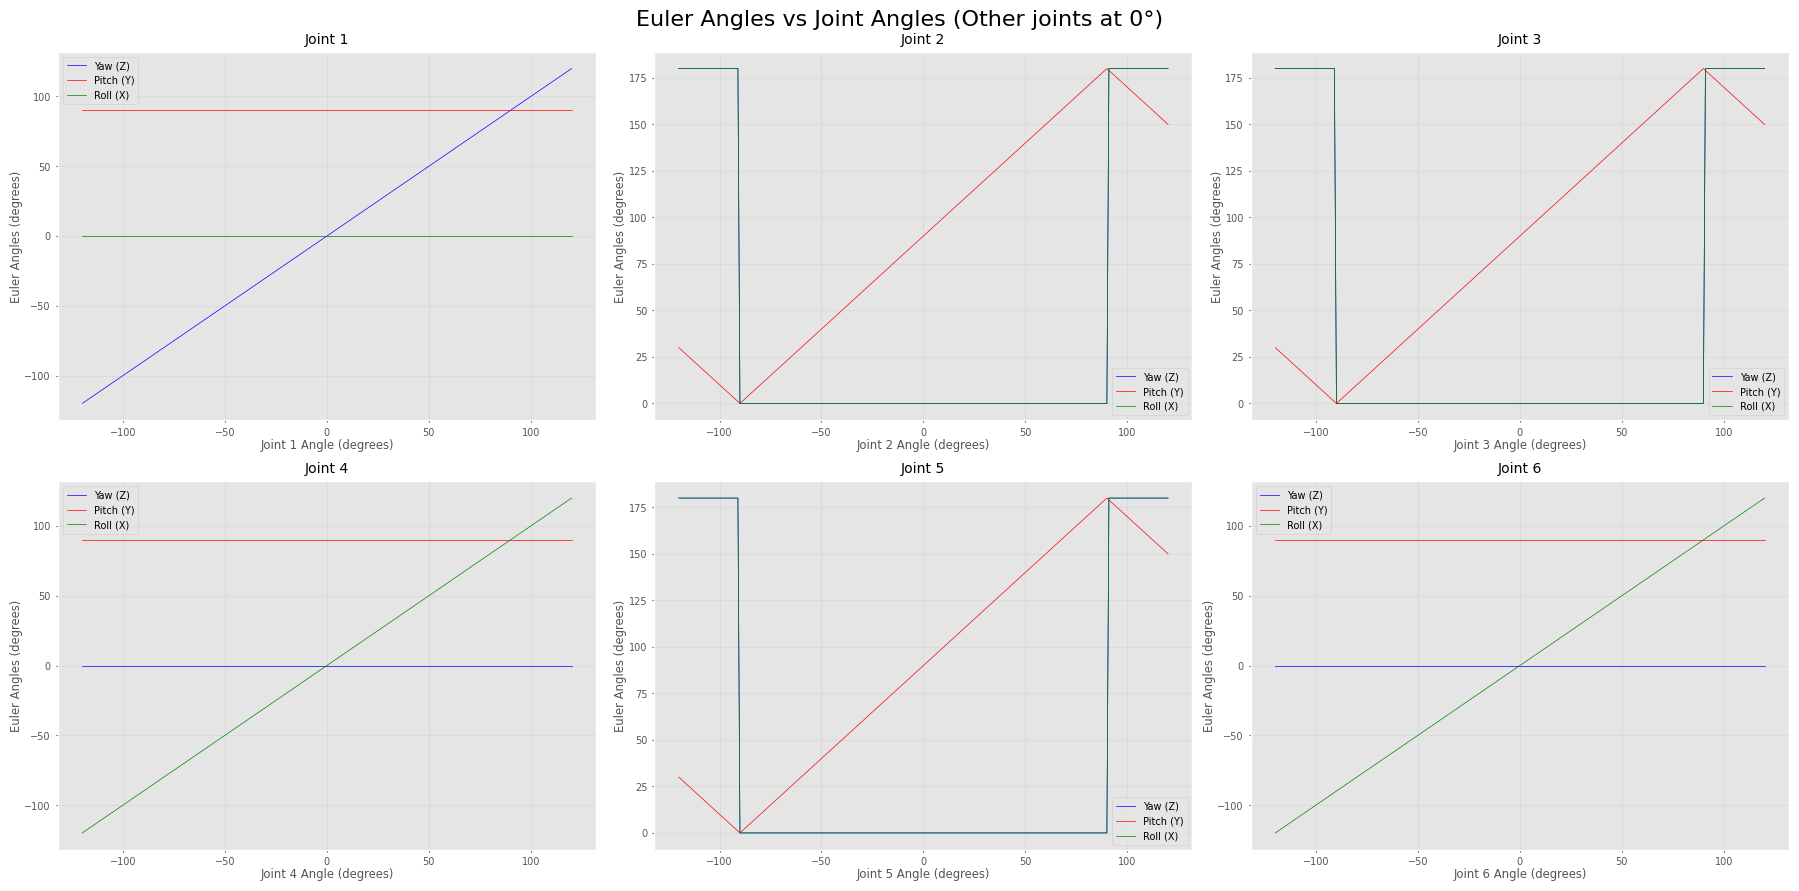

In [3]:
# Generate plots
plot_all_joints(robot, 0)   # All other joints at 0 degrees

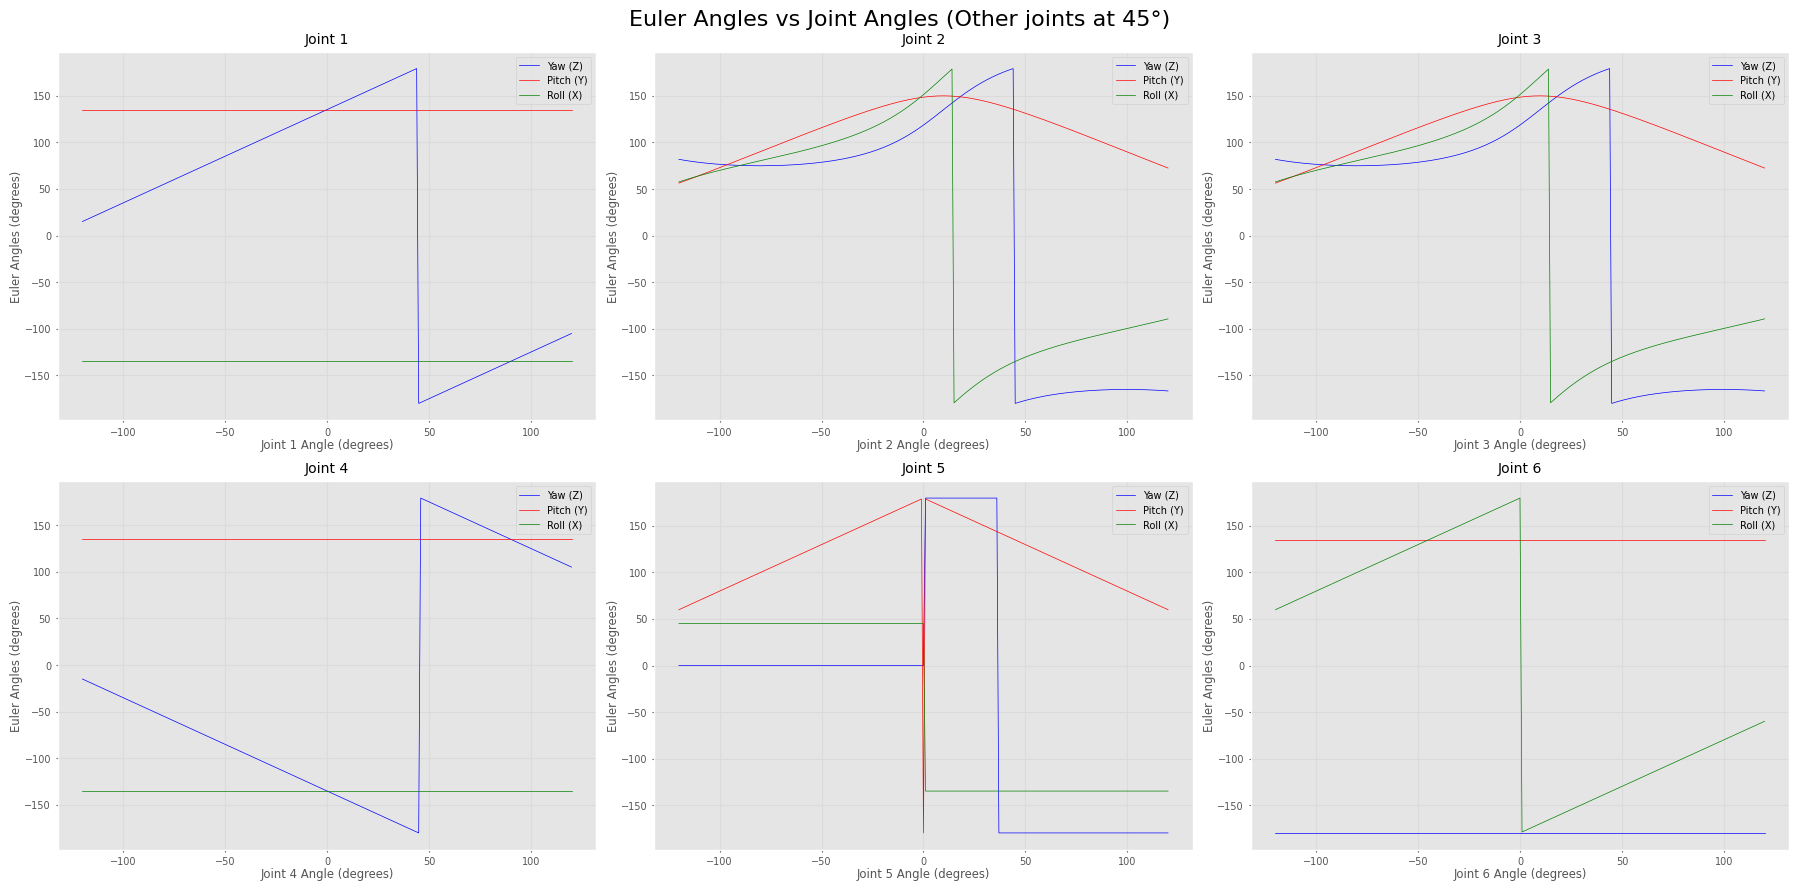

In [4]:
plot_all_joints(robot, 45)  # All other joints at 45 degrees

# Final test implementation

In [11]:
import numpy as np
from spatialmath import SE3
import matplotlib.pyplot as plt

def dh_transform(theta, d, a, alpha):
    """
    Calculate the DH transformation matrix using the provided DH parameters.
    """
    return SE3(np.array([
        [np.cos(theta), -np.sin(theta) * np.cos(alpha),  np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
        [np.sin(theta),  np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),                 d],
        [0,              0,                            0,                             1]
    ]))

def forward_kinematics(dh_params, joint_angles):
    """
    Calculate the forward kinematics for a 6-DOF robotic arm using DH parameters and joint angles.
    
    Parameters:
    dh_params (list of list): Each sublist should contain [theta_home, d, a, alpha] for one joint.
    joint_angles (list): List of joint angles [theta1, theta2, ... theta6] in radians.
    
    Returns:
    SE3: Transformation matrix of the end effector.
    """
    # Check if the number of provided joints and angles are both 6
    if len(dh_params) != 6 or len(joint_angles) != 6:
        raise ValueError("The provided DH parameters and joint angles should be for 6 joints each")
    
    # Initialize transformation matrix as identity
    T = SE3()
    
    for i in range(6):
        theta_home, d, a, alpha = dh_params[i]
        theta = theta_home + joint_angles[i]
        T *= dh_transform(theta, d, a, alpha)
        
    return T

def extract_pose(T):
    """
    Extract the position (X, Y, Z) and ZYX Euler angles from the transformation matrix.
    
    Parameters:
    T (SE3): SE3 transformation matrix.
    
    Returns:
    tuple: (X, Y, Z, Euler ZYX angles in radians)
    """
    pos = T.t
    zyx_euler = T.eul('ZYX')
    return pos[0], pos[1], pos[2], zyx_euler

def test_joint_kinematics(joint_index, initial_angles):
    """
    Test kinematics for a specific joint with given initial angles for other joints.
    
    Args:
    joint_index (int): Index of the joint to vary (0-5)
    initial_angles (list): Initial angles for all joints in degrees
    
    Returns:
    tuple: joint_angles, x, y, z, yaws, pitches, rolls
    """
    joint_angles = np.linspace(-120, 120, 241)
    yaws, pitches, rolls = [], [], []
    x, y, z = [], [], []
    initial_angles_rad = np.radians(initial_angles)
    
    for angle in joint_angles:
        test_angles = initial_angles_rad.copy()
        test_angles[joint_index] = np.radians(angle)
        
        T = forward_kinematics(dh_params, test_angles)
        x_pos, y_pos, z_pos, euler_zyx = extract_pose(T)
        
        x.append(x_pos)
        y.append(y_pos)
        z.append(z_pos)
        yaws.append(np.degrees(euler_zyx[0]))
        pitches.append(np.degrees(euler_zyx[1]))
        rolls.append(np.degrees(euler_zyx[2]))
    
    return joint_angles, x, y, z, yaws, pitches, rolls

def plot_all_joints(initial_angle):
    fig, axs = plt.subplots(4, 3, figsize=(18, 18))
    fig.suptitle(f'Pose and Euler Angles vs Joint Angles (Other joints at {initial_angle}°)', fontsize=16)
    
    for i in range(6):
        initial_angles = [initial_angle] * 6
        joint_angles, x, y, z, yaws, pitches, rolls = test_joint_kinematics(i, initial_angles)
        
        row1, col1 = divmod(i, 3)
        row2, col2 = divmod(i + 6, 3)
        
        # Plotting Euler Angles
        axs[row1, col1].plot(joint_angles, yaws, 'b', label='Yaw (Z)')
        axs[row1, col1].plot(joint_angles, pitches, 'r', label='Pitch (Y)')
        axs[row1, col1].plot(joint_angles, rolls, 'g', label='Roll (X)')
        axs[row1, col1].set_xlabel(f'Joint {i+1} Angle (degrees)')
        axs[row1, col1].set_ylabel('Euler Angles (degrees)')
        axs[row1, col1].set_title(f'Joint {i+1} (Euler Angles)')
        axs[row1, col1].legend()
        axs[row1, col1].grid(True)

        # Plotting Position
        axs[row2, col2].plot(joint_angles, x, 'm', label='X')
        axs[row2, col2].plot(joint_angles, y, 'c', label='Y')
        axs[row2, col2].plot(joint_angles, z, 'y', label='Z')
        axs[row2, col2].set_xlabel(f'Joint {i+1} Angle (degrees)')
        axs[row2, col2].set_ylabel('Position (units)')
        axs[row2, col2].set_title(f'Joint {i+1} (Position)')
        axs[row2, col2].legend()
        axs[row2, col2].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

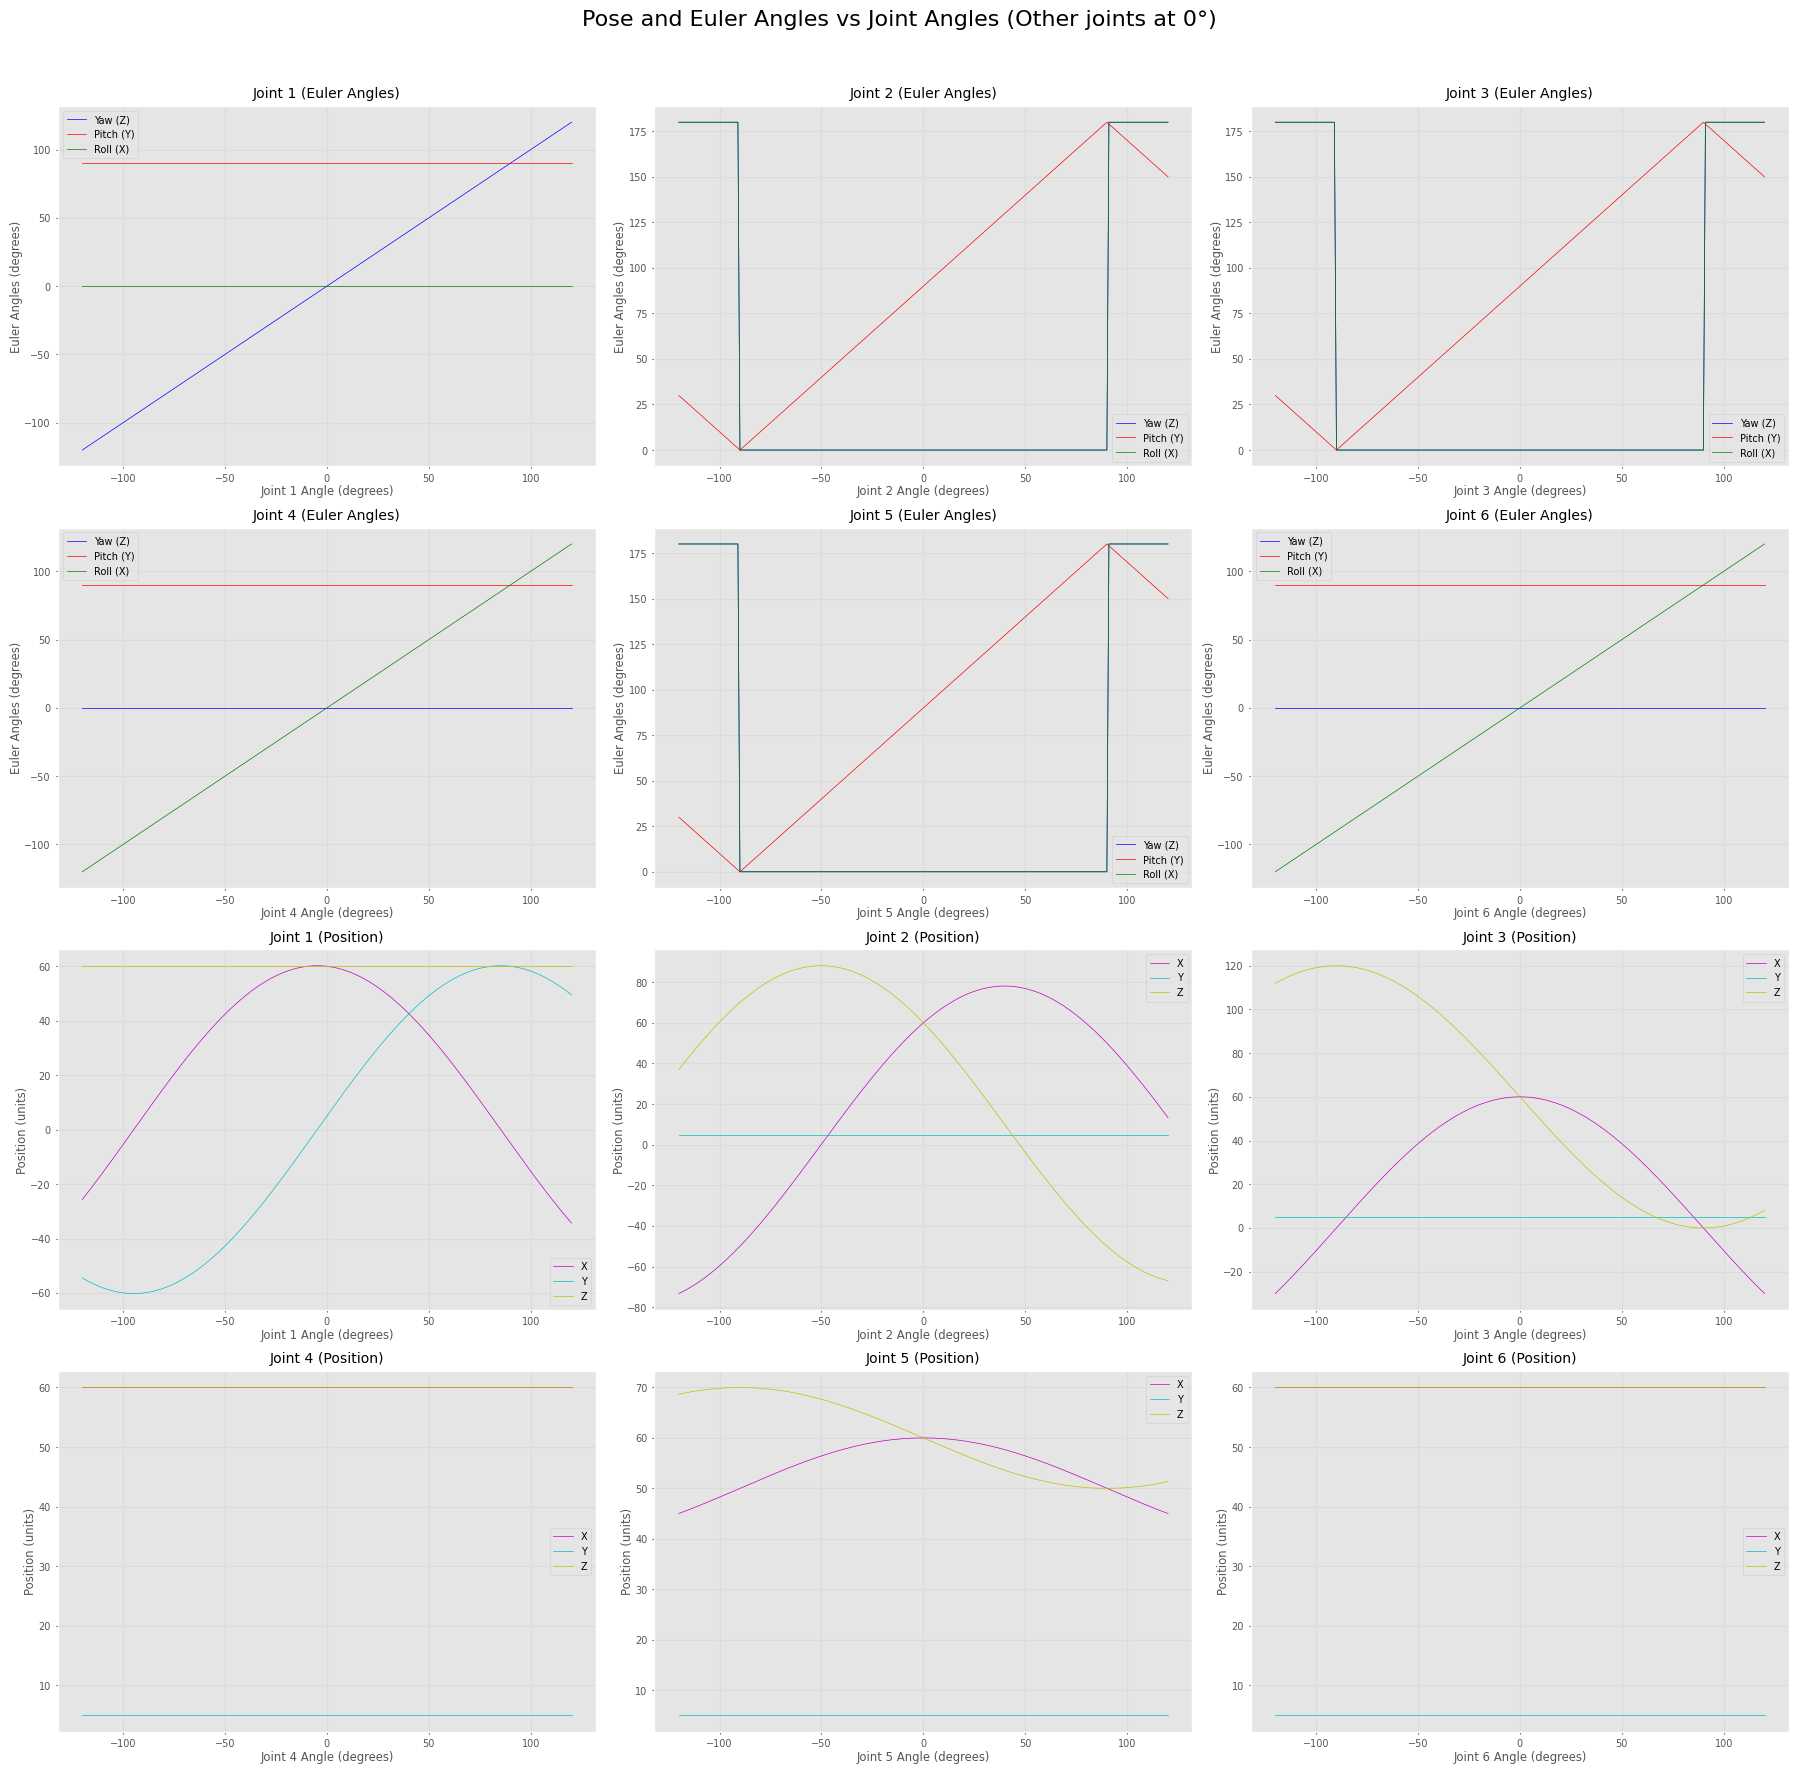

In [12]:
# Provided DH parameters: [theta_home, d, a, alpha]
dh_params = [
    [0, 10, 0, -np.pi/2],
    [-np.pi/2, 0, 50, 0],
    [0, 5, 0, -np.pi/2],
    [0, 50, 0, np.pi/2],
    [0, 0, 0, -np.pi/2],
    [np.pi, 10, 0, 0] # This should be np.pi, considering it as the initial theta position
]

# Plot for all joints with initial angle set to -45°
plot_all_joints(0)

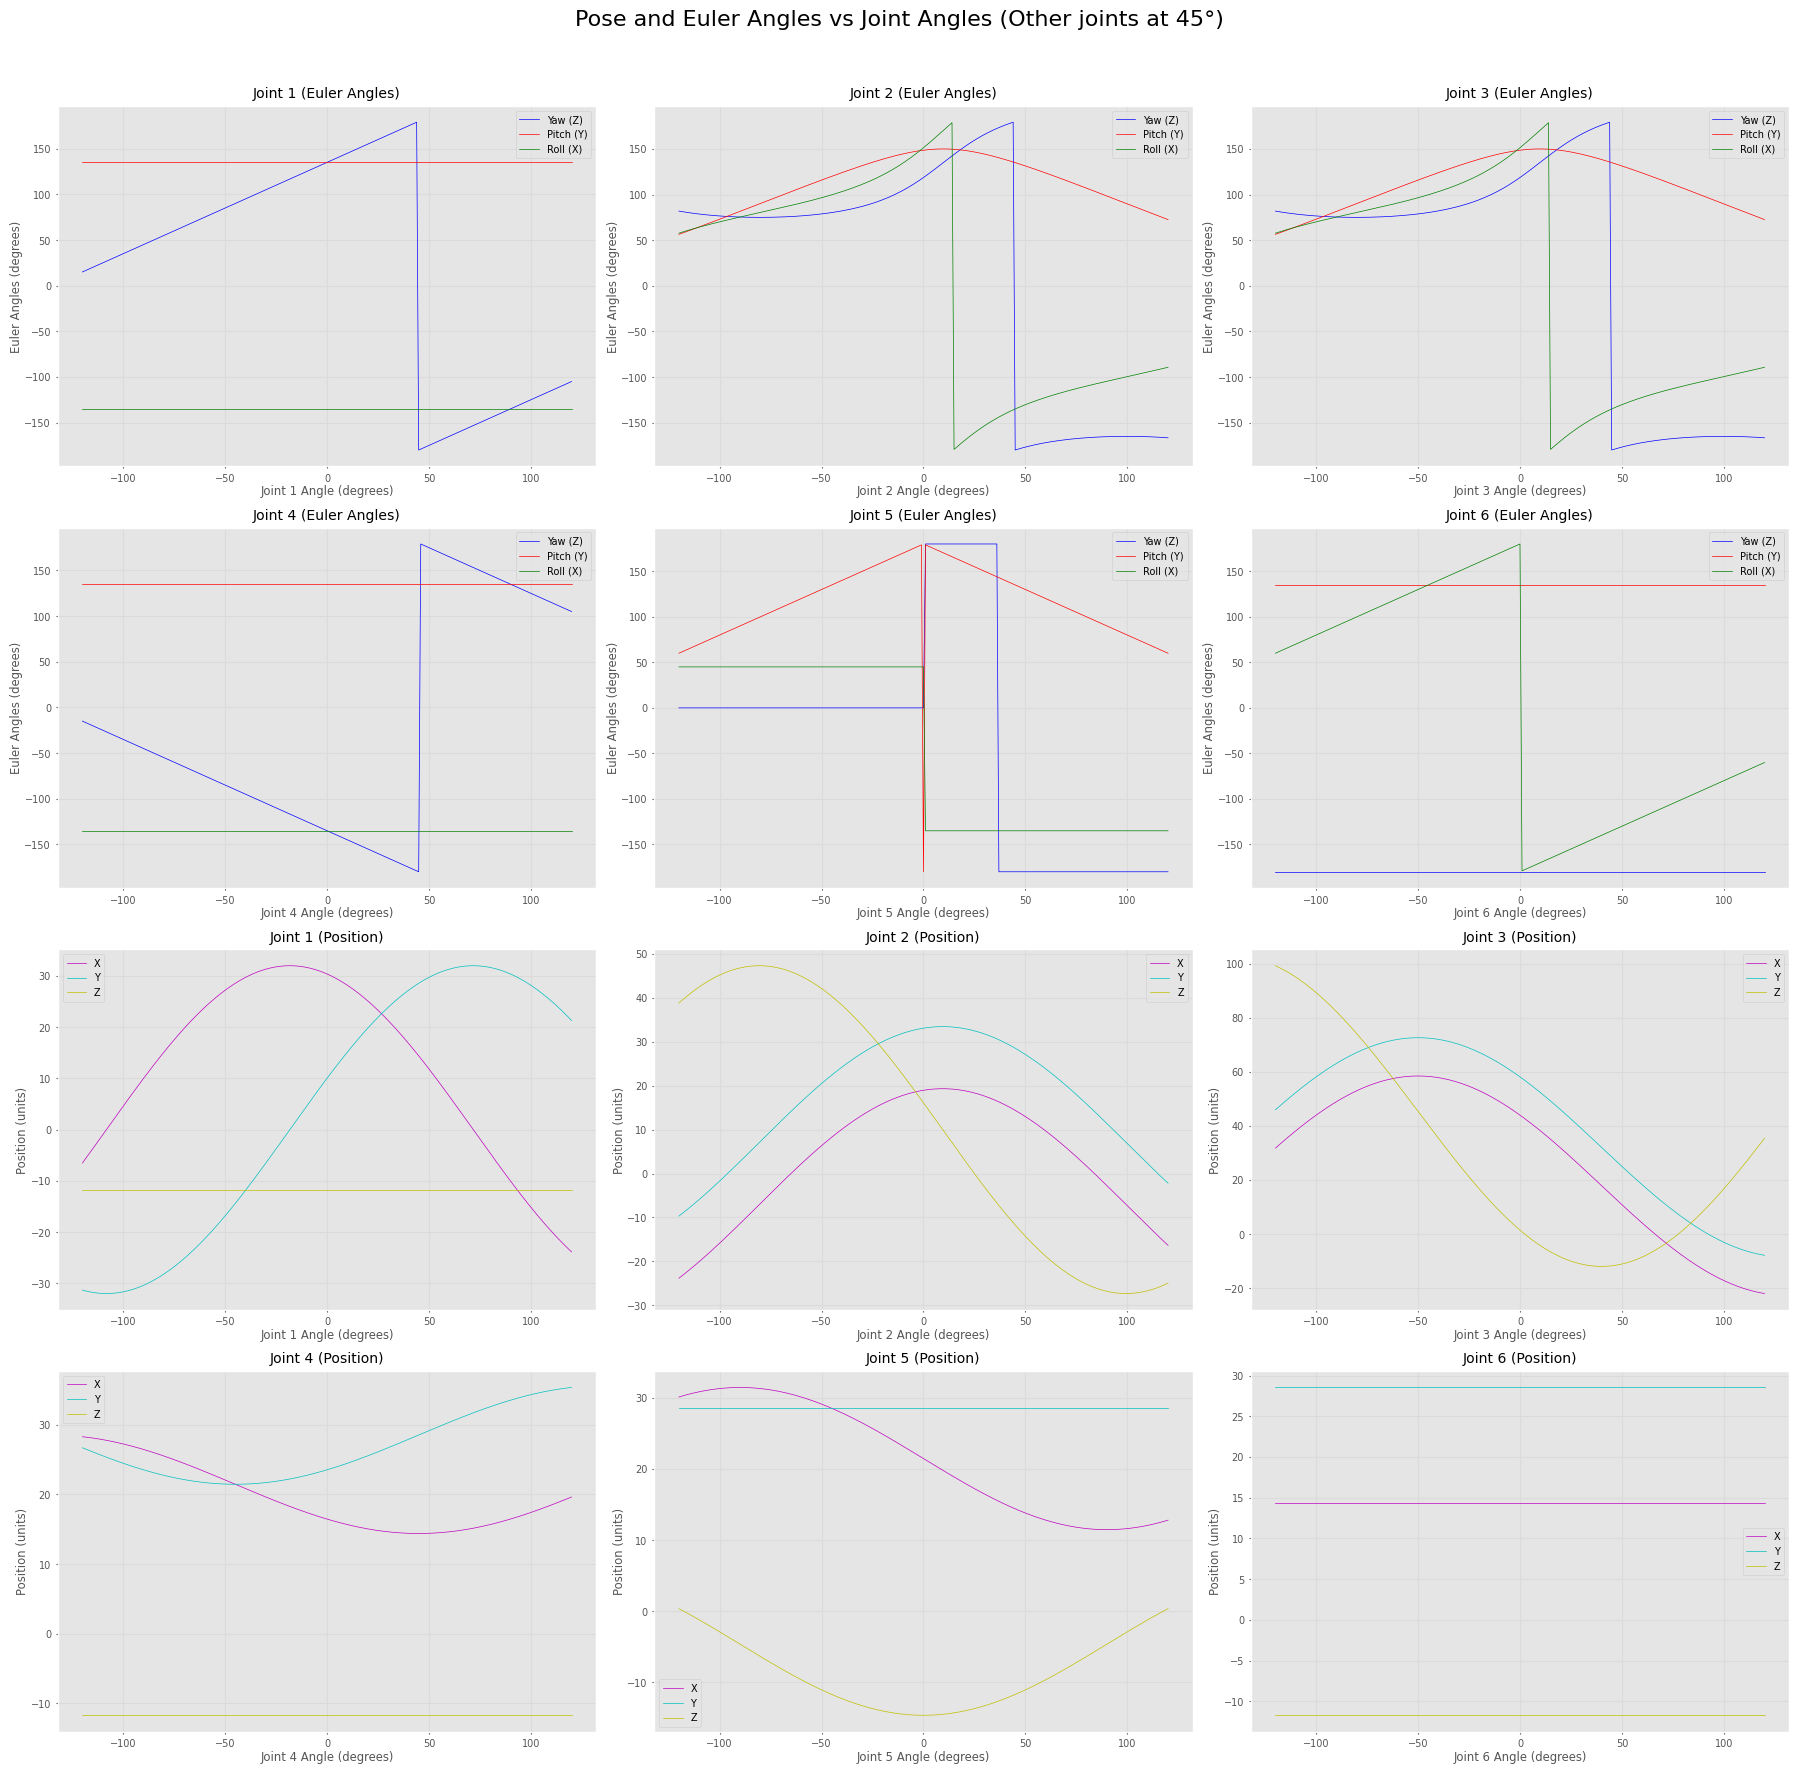

In [13]:
# Plot for all joints with initial angle set to 45°
plot_all_joints(45)

# Class implementation

End Effector Position: X=60.0, Y=5.000000000000001, Z=60.0
End Effector Orientation (Euler ZYX): [ 3.50835465e-15  9.00000000e+01 -3.50835465e-15]


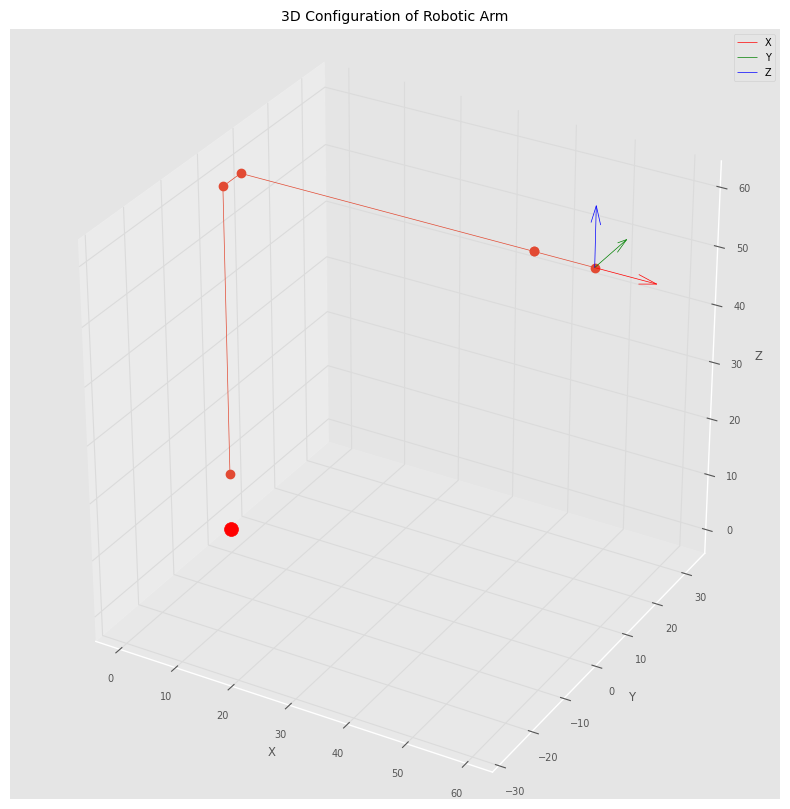

In [16]:
import numpy as np
from spatialmath import SE3
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class RoboticArm:
    def __init__(self, dh_params):
        self.dh_params = dh_params
        self.joint_angles = np.zeros(6)
        self.joint_positions = np.zeros((6, 3))

    def set_dh_params(self, dh_params):
        """
        Set the DH parameters for each joint.
        Args:
            dh_params (list): List of DH parameters [theta_home, d, a, alpha] for each joint.
        """
        self.dh_params = dh_params

    def dh_transform(self, theta, d, a, alpha):
        """
        Calculate the DH transformation matrix using the provided DH parameters.
        """
        return SE3(np.array([
            [np.cos(theta), -np.sin(theta) * np.cos(alpha),  np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
            [np.sin(theta),  np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
            [0,              np.sin(alpha),                np.cos(alpha),                 d],
            [0,              0,                            0,                             1]
        ]))

    def set_pose(self, joint_angles):
        """
        Set the pose of the robotic arm using the provided joint angles.
        Args:
            joint_angles (list): List of joint angles [theta1, theta2, ..., theta6] in degrees.
        Returns:
            np.array: Position of the end effector and Euler ZYX angles.
        """
        joint_angles_rad = np.radians(joint_angles)
        T = SE3()
        self.joint_positions = np.zeros((6, 3))

        for i in range(6):
            theta_home, d, a, alpha = self.dh_params[i]
            theta = theta_home + joint_angles_rad[i]
            T *= self.dh_transform(theta, d, a, alpha)
            self.joint_positions[i, :] = T.t

        x, y, z, euler_zyx = self.extract_pose(T)
        return x, y, z, euler_zyx

    def extract_pose(self, T):
        """
        Extract the position (X, Y, Z) and ZYX Euler angles from the transformation matrix.
        Args:
            T (SE3): SE3 transformation matrix.
        Returns:
            tuple: (X, Y, Z, Euler ZYX angles in radians)
        """
        pos = T.t
        zyx_euler = T.eul('ZYX')
        return pos[0], pos[1], pos[2], zyx_euler

    def plot_3d(self):
        """
        Plot the 3D configuration of the robotic arm and visualize the end effector orientation
        with equal scaling on all axes.
        """
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the joints
        ax.plot(self.joint_positions[:, 0], self.joint_positions[:, 1], self.joint_positions[:, 2], '-o', markersize=6)

        # Plot the base
        ax.scatter(0, 0, 0, color='r', s=100)

        # Plot the end effector with orientation arrows
        end_effector_pos = self.joint_positions[-1, :]
        arrow_length = 10  # Adjust this value to change the length of the orientation arrows
        ax.quiver(end_effector_pos[0], end_effector_pos[1], end_effector_pos[2], 
                  arrow_length, 0, 0, color='r', label='X')
        ax.quiver(end_effector_pos[0], end_effector_pos[1], end_effector_pos[2], 
                  0, arrow_length, 0, color='g', label='Y')
        ax.quiver(end_effector_pos[0], end_effector_pos[1], end_effector_pos[2], 
                  0, 0, arrow_length, color='b', label='Z')

        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Configuration of Robotic Arm')

        # Set equal scaling for all axes
        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()

        x_range = abs(x_limits[1] - x_limits[0])
        y_range = abs(y_limits[1] - y_limits[0])
        z_range = abs(z_limits[1] - z_limits[0])

        max_range = max(x_range, y_range, z_range)

        mid_x = np.mean(x_limits)
        mid_y = np.mean(y_limits)
        mid_z = np.mean(z_limits)

        ax.set_xlim3d([mid_x - max_range / 2, mid_x + max_range / 2])
        ax.set_ylim3d([mid_y - max_range / 2, mid_y + max_range / 2])
        ax.set_zlim3d([mid_z - max_range / 2, mid_z + max_range / 2])

        # Ensure equal aspect ratio
        ax.set_box_aspect((1, 1, 1))

        ax.legend()
        plt.show()

# Sample DH parameters: [theta_home, d, a, alpha]
dh_params = [
    [0, 10, 0, -np.pi/2],
    [-np.pi/2, 0, 50, 0],
    [0, 5, 0, -np.pi/2],
    [0, 50, 0, np.pi/2],
    [0, 0, 0, -np.pi/2],
    [np.pi, 10, 0, 0]
]

# Create a robotic arm instance with the sample DH parameters
robotic_arm = RoboticArm(dh_params)

# Set a specific pose
joint_angles = [0, 0, 0, 0, 0, 0]  # Replace with desired joint angles in degrees
x, y, z, euler_zyx = robotic_arm.set_pose(joint_angles)

print(f"End Effector Position: X={x}, Y={y}, Z={z}")
print(f"End Effector Orientation (Euler ZYX): {np.degrees(euler_zyx)}")

# Plot the 3D configuration of the robotic arm
robotic_arm.plot_3d()